# Let's get started!

## Import modules
Before we start, let's import some modules that we need today. It is good practice to do so at the beginning of a script, so we'll do it right now and not later when we need them. The benefit is that you immediately see if something goes wrong (for instance, because the module is not installed).

In [1]:
import csv
import re
from glob import glob
from string import punctuation
import random
random.seed("ic2s2colgne")
from nltk.sentiment import vader
from nltk.corpus import stopwords
import nltk
from gensim import corpora
from gensim import models
import pyLDAvis
import pyLDAvis.gensim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline
from datetime import datetime
import pprint
pp = pprint.PrettyPrinter(indent=4)

print("STARTING NOW:",str(datetime.now()))


STARTING NOW: 2019-05-15 13:17:42.844015


In [200]:
zeden = pd.read_csv('data/81018ned_UntypedDataSet_10052019_211059.csv', sep=';')

In [201]:
meta = pd.read_csv('data/81018ned_metadata.csv', sep = ';')
meta.reset_index(inplace = True)

meta = meta.iloc[28:-25]
background = meta.iloc[: , [0,1]]
background.rename(columns = {'level_0' : 'Migratieachtergrond', 'level_1' : 'migration_description'}, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4015: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [202]:
background['migration_description'] = background['migration_description'].map(lambda x: x.replace('Migratieachtergrond: ' , ''))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [203]:
zeden['year'] = zeden['Perioden'].map(lambda x: x[0:4])

In [204]:
zeden = pd.merge(zeden, background, on = 'Migratieachtergrond')
zeden.rename(columns = {'ClientenVanSlachtofferhulpNederland_1' : 'victims_absolute', 'ClientenVanSHNPer100000Inwoners_2' : 'victims_relative'}, inplace=True)
zeden.drop(['TypeClient', 'TypeDelict' , 'Geslacht' , 'Leeftijd', 'Perioden', 'Migratieachtergrond' , 'ID'], axis = 1, inplace=True)


In [205]:
victims_absolute = zeden.pivot(index='year', columns='migration_description', values='victims_absolute')
victims_relative = zeden.pivot(index='year', columns='migration_description', values='victims_relative')

## Total number of articles in Trouw and AD

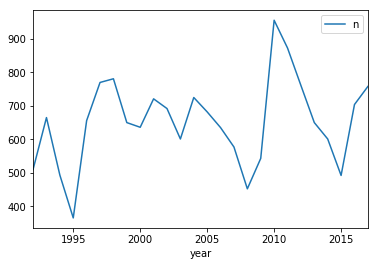

In [206]:
PATH = 'data/'
df = pd.read_csv(PATH + 'trouw_ad.csv')
df.columns = ['title','title_rss','doctype', 'publication_date', 'byline', 'teaser_rss', 'url',  'text']
df['date'] = pd.to_datetime(df['publication_date'], errors='coerce')
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['year']
df['YearMonth'] = df['date'].map(lambda x: 100*x.year + x.month)
df['n'] = 1
df = df[pd.notnull(df['text'])]

df_yearly = df.groupby('year', as_index=False).agg({'n': sum})
df_yearly.groupby('year').agg({'n': sum}).plot()

In [207]:
n_yearly = pd.read_pickle('data/yearly_largestnp.pkl')
#n_yearly.sort_values(['year'], ascending=True)

In [208]:
combined = pd.merge(df_yearly, n_yearly, on = 'year')
combined['relative'] =  combined['n'] /  ( combined['ad'] + combined['trouw'] )  * 100
combined['total_attention'] = ( combined['ad'] + combined['trouw']  ) / 50

In [283]:
#victims_relative['year'] = victims_relative.index

In [209]:
victims_relative.reset_index(inplace=True)

In [210]:
victims_relative['year'] = victims_relative['year'].astype(int) 

In [211]:
combined = pd.merge(combined, victims_relative, on = 'year', how='outer')

In [212]:
combined['Nederland'] = combined['Nederland'] / 100

In [213]:
combined['niet-westers'] = combined['niet-westers'] / 100

In [214]:
combined['Totaal'] = combined['Totaal'] / 100

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/legend.py:508: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


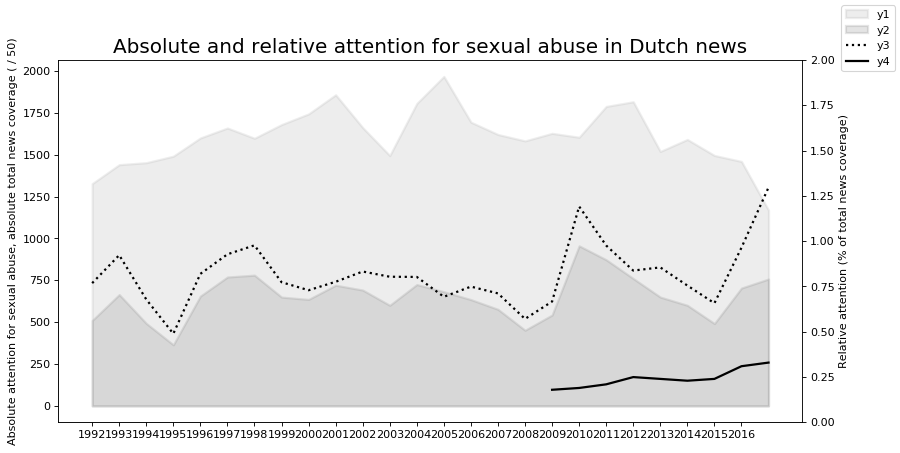

In [18]:
import numpy as np

# Prepare Data
x = combined['year'].values.tolist()
y1 = combined['total_attention'].values.tolist()
y2 = combined['n'].values.tolist()
y3 = combined['relative'].values.tolist()
y4 = combined['Nederland'].values.tolist()
y5 = combined['niet-westers'].values.tolist()
y6 = combined['Totaal'].values.tolist()

mycolors = ['gray', 'darkgray', 'tab:grey',  'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      
columns = ['absolute attention', 'total coverage', 'relative attention']
dashList = [(5,2),(2,5),(4,10),(3,3,2,2),(5,2,20,2)] 

# Draw Plot 
#fig, ax1 = plt.subplots(1, 1, figsize=(16,9), dpi= 80)
fig, ax1 = plt.subplots(1, 1, figsize=(12,6), dpi= 80)
ax1.fill_between(x, y1=y1, y2=0, label=columns[1], alpha=0.2, color=mycolors[1], linewidth=2)
ax1.fill_between(x, y1=y2, y2=0, label=columns[0], alpha=0.2, color=mycolors[0], linewidth=2)

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y3, color='black', linestyle= ':', linewidth = 2, label=columns[2])
#ax2.plot(x, y4, color='black', linestyle= ':', linewidth = 2)
#ax2.plot(x, y5, color='black', linestyle= '-.', linewidth = 2)
ax2.plot(x, y6, color='black', linestyle= '-', linewidth = 2)

# Decorations
ax1.set_title('Absolute and relative attention for sexual abuse in Dutch news', fontsize=18)
ax1.set_ylabel("Absolute attention for sexual abuse, absolute total news coverage ( / 50)", color='black', fontsize=10)
ax1.set(ylim=[0.0, 2500.0])
#ax1.legend(loc='best', fontsize=12)
plt.xticks(fontsize=10, horizontalalignment='center')
plt.xticks(np.arange(min(x), max(x), 1.0))
#plt.yticks(np.arange(2.5, 200000), fontsize=10)
plt.xlim(1992, 2017)


# ax2 (right Y axis)
ax2.set_ylabel("Relative attention (% of total news coverage)", color='black', fontsize=10)
ax2.tick_params(axis='y', labelcolor='black')
#ax2.set_xticks(np.arange(0, len(x), 60))
#ax2.set_xticklabels(x[::60], rotation=90, fontdict={'fontsize':10})
ax2.set(ylim=(0, 2))

ax1.figure.legend(['y1','y2','y3','y4'], loc="best", bbox_transform=ax1.transAxes)
ax1.autoscale(enable=True, axis='both', tight=False)

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)
plt.show()

## Let's start!
Let's retrieve a list of all speeches from one of the files. Of course, we could also loop over all the files...

In [215]:
PATH = 'data/'
df = pd.read_csv(PATH + 'trouw_ad.csv')
df.columns = ['title','title_rss','doctype', 'publication_date', 'byline', 'teaser_rss', 'url',  'text']
df['date'] = pd.to_datetime(df['publication_date'], errors='coerce')
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['year']
df['YearMonth'] = df['date'].map(lambda x: 100*x.year + x.month)
df['n'] = 1
df = df[pd.notnull(df['text'])]

In [216]:
df = df[pd.notnull(df['text'])]
body_of_text = list(df['text'])

In [217]:
len(df)

16949

# 2. From text to features: preprocessing, tokens, n-grams
## General approach

From a machine-learning perspective, one could argue that all information in a text might be useful information. However, we are interested in getting *interpretable* topics, so even if for instance the use of specific HTML tags would help us distinguising between some documents, we want to get rid of them. More in general, we start by cleaning up a bit to get only 'real' text.

### Some typical clean-up steps:

In [218]:
body_of_text=["".join([l for l in speech if l not in punctuation]) for speech in body_of_text]  #remove punctuation
body_of_text=[speech.lower() for speech in body_of_text]  # convert to lower case
body_of_text=[" ".join(speech.split()) for speech in body_of_text]   # remove double spaces by splitting the strings into words and joining these words again

Let's look at the first speech to check everything's fine.

In [219]:
body_of_text[0][:501]

'haarlem anp een huisarts uit velsen die door het medisch tuchtcollege in amsterdam is geschorst wegens seksueel misbruik van enkele patientes moet verplicht een aidstest ondergaan dat heeft de president van de rechtbank in haarlem mr g de groot gisteren in kort geding bepaald de arts was voor de rechter gedaagd door een van de acht vrouwen die eind vorig jaar aangifte deden van seksueel misbruik de man moet in december terechtstaan voor de rechtbank in haarlem de arts is in hoger beroep gegaan te'

However, as with other unsupervised machine learning techniques, we are not really interesting a long string of text. We rather want to have each document being represented by a set of *features*. To this end, `gensim` has a finciton `doc2bow` that converts a list of words (tokens) to `(token_id, token_count)` tuples. 

Let's just run a simple LDA on this to check out whether it works. We specify the corpus (in wich each document is represented by a `(token_id, token_count)` tuple), the table to translate the token_id's back to words, and the number of topics we want. 

## Stopwords
We immediately see that the result of our first LDA doesn't make much sense: We see only stopwords. 


### Explicit stopword removal
The most straightforward approach is to use a pre-existing list with stopwords, possibly with the addition of some own, case-specific words. We then split up each speech in words, and only if a word is not on the stopwordlist, we keep it and join it with the previous and next word using a space.

In [220]:
mystopwords = stopwords.words('dutch')
extra_stop = [line.strip() for line in open('stopwords/stopwords_NL.txt').readlines() if len(line)>1]
mystopwords = set(mystopwords + extra_stop)

text_clean = [" ".join([w for w in speech.split() if w not in mystopwords]) for speech in body_of_text]
text_clean = [" ".join([w for w in speech.split() if w.isalpha()]) for speech in text_clean] # keep only words, no digits

In [221]:
text_clean[60:][110]

'thriller natuurlijke oorzaken james oswald hippe schotse veehouder schrijft griezelig boek zelden zon geruststellende foto achterkant thriller gezien hipsterachtige man omringd schapen kijkt vriendelijk schotse auteur james oswald fokt schapen koeien tussendoor schrijft thrillers horrorverhalen daarbij spaart lezer edinburgh natuurlijke oorzaken afspeelt vooraanstaande oudere mannen gruwelijke wijze vermoord lichamen opengesneden stukjes organen monden gestopt liggen vloer inspecteur mclean zaak onderzoekt stapt middenin verwacht maclean hevig geïntrigeerd raken zaak plaats daarvan vraagt zaak aandacht verzegelde kamer oud huis gemummificeerde lijk jong meisje gevonden ruim zestig gemarteld verkracht grond vastgespijkerd dichtgemetselde nissen muur organen meisje verborgen liggen briefjes naast wonderlijke woorden erop wombat toots professor zaak laat mclean los mclean sombere inspecteur soort scandinavische thrillers aantreft schot laat regelmatig kroeg slepen studievrienden zowaar p

In [222]:
speeches_nl_bigrams = [["_".join(tup) for tup in nltk.ngrams(speech.split(),2)] for speech in text_clean]

In [223]:
# maybe we want both unigrams and bigrams in the feature set?
assert len(text_clean)==len(speeches_nl_bigrams)
speeches_nl_uniandbigrams = []
for a,b in zip([speech.split() for speech in text_clean],speeches_nl_bigrams):
    speeches_nl_uniandbigrams.append(a + b)

In [224]:
len(speeches_nl_uniandbigrams[6]),len(speeches_nl_bigrams[6]),len(text_clean[6].split())

(141, 70, 71)

In [225]:
id2word_m5 = corpora.Dictionary(speeches_nl_uniandbigrams)                       
id2word_m5.filter_extremes(no_below=40, no_above=0.5)
ldacorpus_m5 = [id2word_m5.doc2bow(doc) for doc in speeches_nl_uniandbigrams]
tfidfcorpus_m5 = models.TfidfModel(ldacorpus_m5)

In [226]:
len(text_clean) == len(speeches_nl_uniandbigrams)

True

In [356]:
NUM_TOPICS = 10
lda_m5 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m5[ldacorpus_m5],id2word=id2word_m5,num_topics=NUM_TOPICS)

In [357]:
lda_m5.show_topics(num_topics=-1, num_words=4, formatted=False)
#pp.pprint(lda_m5.show_topics(num_topics=-1, num_words=50, formatted=False))

[(0,
  [('jackson', 0.024226535),
   ('michael', 0.010470902),
   ('michael_jackson', 0.010209729),
   ('assange', 0.008272309)]),
 (1,
  [('voorwaardelijke', 0.009369643),
   ('vaatstra', 0.008787437),
   ('maanden_voorwaardelijke', 0.0069882185),
   ('voorwaardelijke_celstraf', 0.006920006)]),
 (2,
  [('vrouwen', 0.001656175),
   ('kinderen', 0.0015958515),
   ('mensen', 0.0015462267),
   ('kerk', 0.001509743)]),
 (3,
  [('weinstein', 0.010865649),
   ('rechtbank_leeuwarden', 0.008816819),
   ('harvey', 0.007081435),
   ('robin', 0.0069558197)]),
 (4,
  [('yolanda', 0.014985885),
   ('epe', 0.009137771),
   ('z', 0.009030971),
   ('capelle', 0.006907402)]),
 (5,
  [('vrouwen', 0.0037122988),
   ('geweld', 0.0026503801),
   ('intimidatie', 0.0025293422),
   ('seksuele_intimidatie', 0.0023081144)]),
 (6,
  [('strausskahn', 0.010114034),
   ('gouda', 0.0066693537),
   ('kamermeisje', 0.0066323397),
   ('uur_werkstraf', 0.006601352)]),
 (7,
  [('ontucht', 0.0069646323),
   ('politie', 0.

### Save top words to df 'topic_labels'

In [364]:
top_words_per_topic = []
for t in range(lda_m5.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_m5.show_topic(t, topn = 10)])

topic_labels = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P'])
topic_labels = topic_labels.groupby(['Topic'])['Word'].apply(lambda x: ', '.join(x)).reset_index()

topic_labels['topic_words']=topic_labels['Topic'].astype(str)+' = '+topic_labels['Word']
topic_labels.rename(columns={'Topic':'topic_id'}, inplace=True)
topic_labels = topic_labels[['topic_id' , 'topic_words']]

In [367]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [368]:
scoresperdoc=lda_m5.inference(ldacorpus_m5)

In [369]:
results = pd.DataFrame.from_records(scoresperdoc[0])
results = results.div(results.sum(axis = 1), axis = 0)

In [370]:
len(df) == len(results)

True

In [371]:
top = list(range(0,NUM_TOPICS))
#df.reset_index(inplace=True)
new = pd.concat([results, df], axis=1)
new['index1'] = new.index

new = pd.melt(new, id_vars = ['title', 'publication_date', 'year', 'index1'], value_vars=top, value_name = 'norm_topic_weight', var_name = 'topic_id')
new.rename(columns={'variable':'topic_id','value':'norm_topic_weight', 'index1' : 'doc_id'}, inplace=True)
#len(new) = len(results)


In [372]:
new = pd.merge(new, topic_labels, on='topic_id')

In [374]:
df_sum = new[new['norm_topic_weight'].round(3) != 0]

In [375]:
print("Max: {}".format(df_sum['norm_topic_weight'].max()))
print("Min: {}".format(df_sum['norm_topic_weight'].min()))
print("Average: {}".format(df_sum['norm_topic_weight'].mean()))
print("Median: {}".format(df_sum['norm_topic_weight'].median()))
print("Most frequent value: {}".format(df_sum['norm_topic_weight'].round(5).value_counts().idxmax()))

Max: 0.632607413522998
Min: 0.0009676675532245253
Average: 0.03125
Median: 0.019231120439830763
Most frequent value: 0.02056


In [112]:
# Load the necessary libraries
import gensim # Note: I am running 1.0.1
#from ggplot import *
import json
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd # Note: I am running 0.19.2
import pyLDAvis.gensim
import seaborn as sns
import warnings

In [39]:
vis_data = pyLDAvis.gensim.prepare(lda_m5,ldacorpus_m5,id2word_m5)
pyLDAvis.display(vis_data)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 0.98, 'Scatterplot of Normalized Topic Weights, Split by Topic; All Weights.')

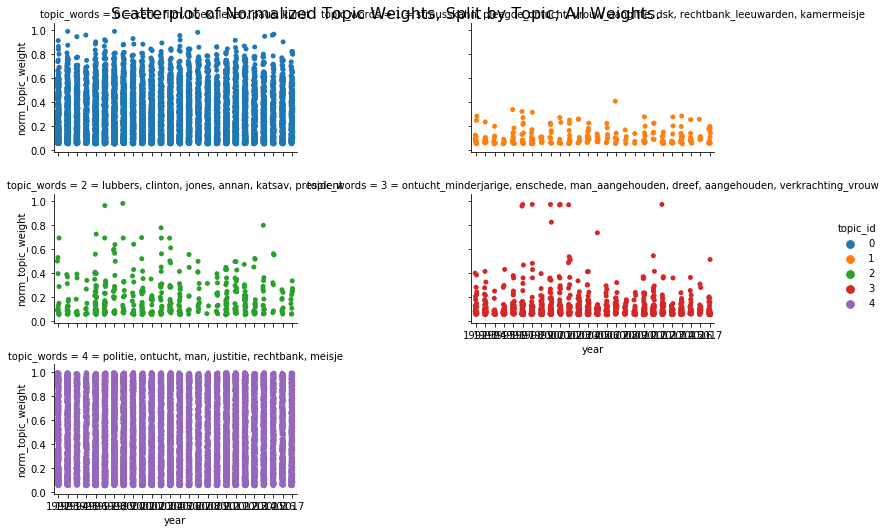

In [283]:
p = sns.factorplot(x="year", y='norm_topic_weight', hue="topic_id", col='topic_words', col_wrap=2, 
                   kind='strip', size=2.5, aspect=2, jitter=1, data=df_sum)
p.fig.subplots_adjust(top=0.95)
p.fig.suptitle("Scatterplot of Normalized Topic Weights, Split by Topic; All Weights.", fontsize=16)

In [376]:
def create_pointplot(df, y_value, hue=None,  col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.catplot(x="year", y=y_value, kind='point',  hue=hue, 
                       col=col, col_wrap=wrap, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

In [377]:
def create_bar(df, y_value, hue=None,  col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.factorplot(x="year", y=y_value, kind='bar', hue=hue, 
                       col=col, col_wrap=wrap, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


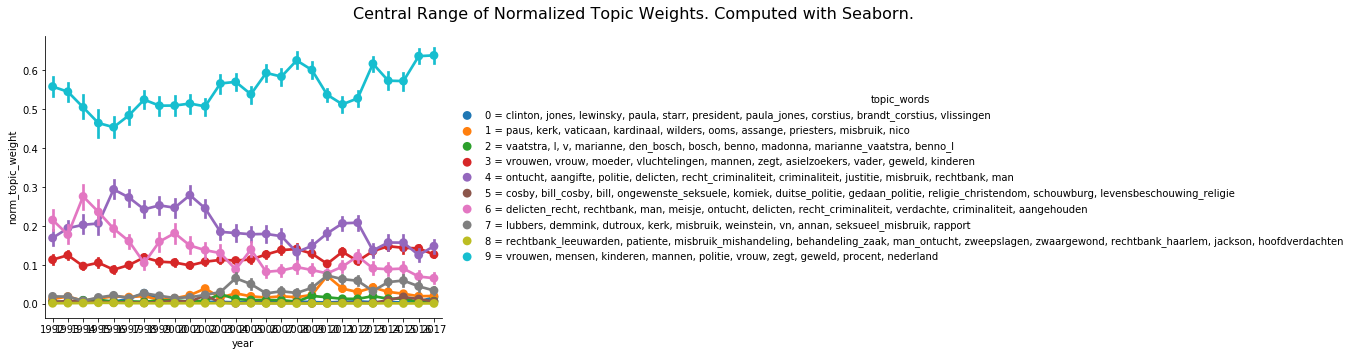

In [247]:
create_pointplot(df_sum, 'norm_topic_weight', hue='topic_words', size=5, aspect=1.5,
                 title="Central Range of Normalized Topic Weights. Computed with Seaborn.")

In [174]:
df_sum.groupby('title').describe()

year                   \
                                                    count    mean      std   
title                                                                        
                                     dinsdag        100.0  2007.1  1.04929   
                                     dinsdag 'A...   10.0  2007.0  0.00000   
                                     dinsdag 'E...   10.0  2006.0  0.00000   
                                     dinsdag 'F...   10.0  2007.0  0.00000   
                                     dinsdag 'J...    4.0  2006.0  0.00000   
                                     dinsdag 'M...   10.0  2008.0  0.00000   
                                     dinsdag 'V...   10.0  2008.0  0.00000   
                                     dinsdag 10...   10.0  2007.0  0.00000   
                                     dinsdag Aa...   10.0  2008.0  0.00000   
                                     dinsdag Aa...   10.0  2008.0  0.00000   
                                     dinsdag Af...    5.0  2006.0  0.00000   
                                     dinsdag Af...   10.0  2008.0  0.00000   
                                     dinsdag Be...   10.0  2007.0  0.00000   
                                     dinsdag Bl...   10.0  2006.0  0.00000   
                                     dinsdag Bo...    4.0  2006.0  0.00000   
                                     dinsdag Co...   10.0  2006.0  0.00000   
                                     dinsdag Co...   10.0  2007.0  0.00000   
                                     dinsdag Co...   10.0  2008.0  0.00000   
                                     dinsdag De...    4.0  2008.0  0.00000   
                                     dinsdag De...    5.0  2006.0  0.00000   
                                     dinsdag De...   10.0  2006.0  0.00000   
                                     dinsdag Do...   10.0  2007.0  0.00000   
                                     dinsdag Ec...   10.0  2008.0  0.00000   
                                     dinsdag Ee...    3.0  2007.0  0.00000   
                                     dinsdag Ee...    4.0  2008.0  0.00000   
                                     dinsdag Eg...    3.0  2007.0  0.00000   
                                     dinsdag Er...    3.0  2006.0  0.00000   
                                     dinsdag Ex...   10.0  2008.0  0.00000   
                                     dinsdag Ex...   10.0  2009.0  0.00000   
                                     dinsdag Fr...   10.0  2009.0  0.00000   
...                                                   ...     ...      ...   
Wint fipronilei of wordt het de warmtezombie?        10.0  2017.0  0.00000   
Woede in India na aanrandingen                       10.0  2017.0  0.00000   
Woede over vrijspraak voor Franse kinderverkrac...   10.0  2017.0  0.00000   
Zakenman 'Mr. Gus' krijgt 19 jaar cel                 4.0  2017.0  0.00000   
Ze deed zelf het aanzoek, overtuigd te huwen me...   10.0  2017.0  0.00000   
Ze lieten een digitale boer, maar onderschatten...    5.0  2017.0  0.00000   
Zedendelinquent in de VS krijgt stempel in pasp...   10.0  2017.0  0.00000   
Zedenzaak brengt zetel in gevaar                      3.0  2017.0  0.00000   
Zedenzaken zijn langdurig en pijnlijk, en vaak ...    5.0  2017.0  0.00000   
Zes jonge honden en een rauw verhaal met helder...   10.0  2017.0  0.00000   
Zo zijn de Chinese mannen niet, toch?                10.0  2017.0  0.00000   
Zomer vol problemenvoor paus Franciscus               4.0  2017.0  0.00000   
Zwagerman                                            10.0  2017.0  0.00000   
Zwangere 10-jarige schokt India                       5.0  2017.0  0.00000   
Zweden zet tieners uit naar Afghanistan              10.0  2017.0  0.00000   
[1 4 3 2...]*                                        10.0  2017.0  0.00000   
[Haagse rappers blijven vast De zaak tegen drie...   10.0  2017.0  0.00000   
correctie                                            20.0  2017.0  0.00000 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


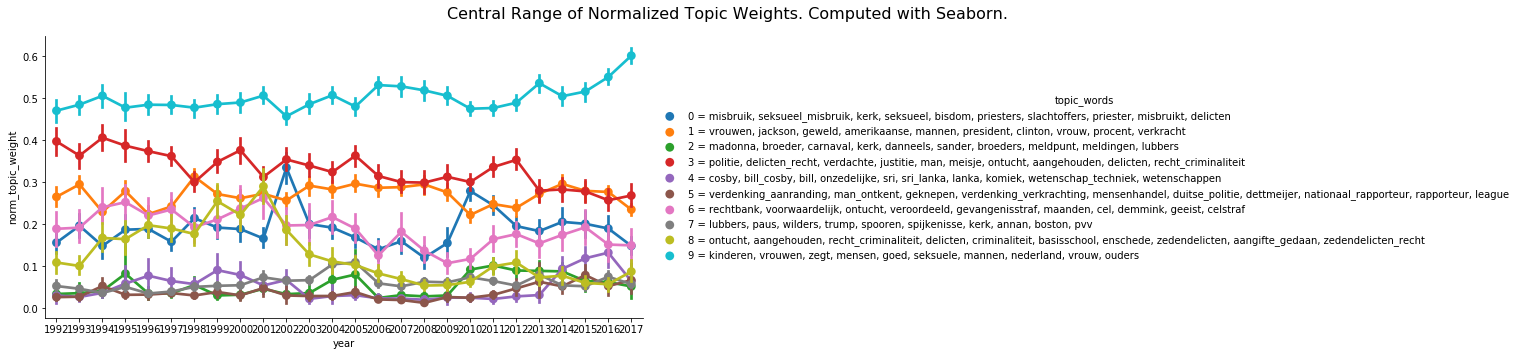

In [119]:
create_pointplot(df_filtered, 'norm_topic_weight', hue='topic_words', size=5, aspect=2,
                 title="Central Range of Normalized Topic Weights. Computed with Seaborn.")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


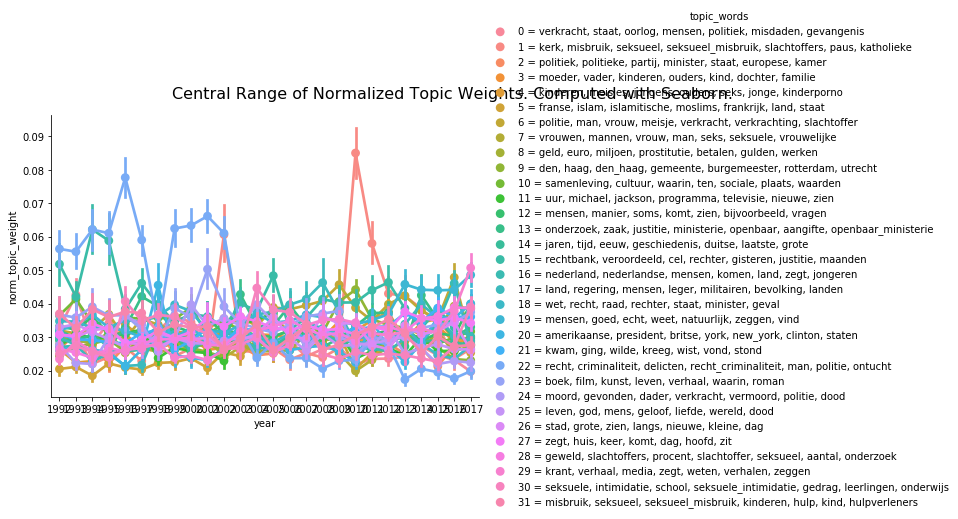

In [379]:
create_pointplot(df_sum, 'norm_topic_weight', hue='topic_words', size=5, aspect=1.5,
                 title="Central Range of Normalized Topic Weights. Computed with Seaborn.")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


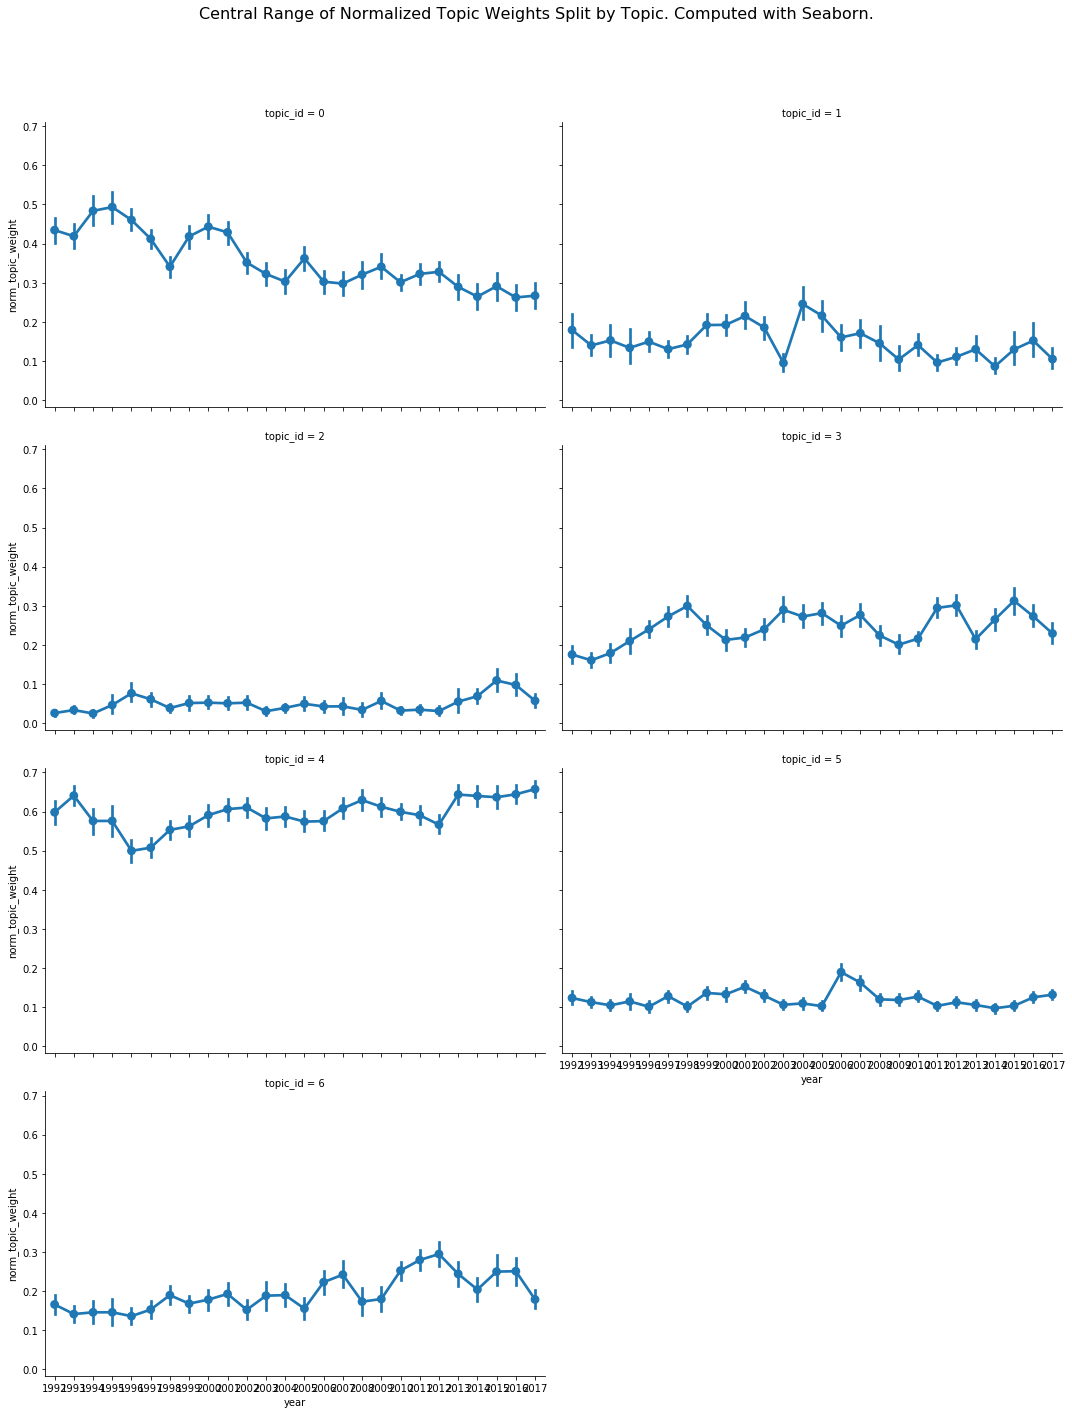

In [134]:
create_pointplot(df_sum, 'norm_topic_weight', col='topic_id', wrap=2, 
                 title="Central Range of Normalized Topic Weights Split by Topic. Computed with Seaborn.")

In [380]:
# Group by document and take the row with max topic weight for each document
df_2 = new
max_df = df_2[df_2.groupby(['doc_id'])['norm_topic_weight'].transform(max) == df_2['norm_topic_weight']]

# Group by year and topic, counting the number of documents per topic per year.
max_counts = max_df[['doc_id', 'year', 'topic_id']].groupby(['year', 'topic_id']).agg({'doc_id' : 'count'}).reset_index()
max_counts.columns = ['year', 'topic_id', 'max_count']

In [381]:
# Count the number of individual documents per year
total_docs = max_df[['year', 'doc_id']].groupby('year').agg({'doc_id' : 'count'}).reset_index()
total_docs.columns = ['year', 'total_docs']

In [382]:
# Combine the two dataframes
max_counts = max_counts.merge(total_docs, on='year', how='left')

# Create a new column with the count per topic divided by the total docs per year
max_counts['prevalence'] = max_counts['max_count']/max_counts['total_docs']

# Add the topic labels to make human-readable
max_counts = max_counts.merge(topic_labels, on="topic_id")


In [385]:
max_counts

,year,topic_id,max_count,total_docs,prevalence,topic_words
0,1992,0,23,510,0.045098,"0 = verkracht, staat, oorlog, mensen, politiek..."
1,1993,0,54,665,0.081203,"0 = verkracht, staat, oorlog, mensen, politiek..."
2,1994,0,17,493,0.034483,"0 = verkracht, staat, oorlog, mensen, politiek..."
3,1995,0,16,365,0.043836,"0 = verkracht, staat, oorlog, mensen, politiek..."
4,1996,0,16,656,0.024390,"0 = verkracht, staat, oorlog, mensen, politiek..."
5,1997,0,20,770,0.025974,"0 = verkracht, staat, oorlog, mensen, politiek..."
6,1998,0,22,781,0.028169,"0 = verkracht, staat, oorlog, mensen, politiek..."
7,1999,0,36,650,0.055385,"0 = verkracht, staat, oorlog, mensen, politiek..."
8,2000,0,30,636,0.047170,"0 = verkracht, staat, oorlog, mensen, politiek..."
9,2001,0,27,721,0.037448,"0 = verkracht, staat, oorlog, mensen, politiek..."


In [383]:
def create_plotpoint(df, y_value, hue=None,  col=None, wrap=None, size=6, aspect=1.5, title=""):
    p = sns.factorplot(x="year", y=y_value, kind='point',  hue=hue, 
                       col=col, col_wrap=wrap, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


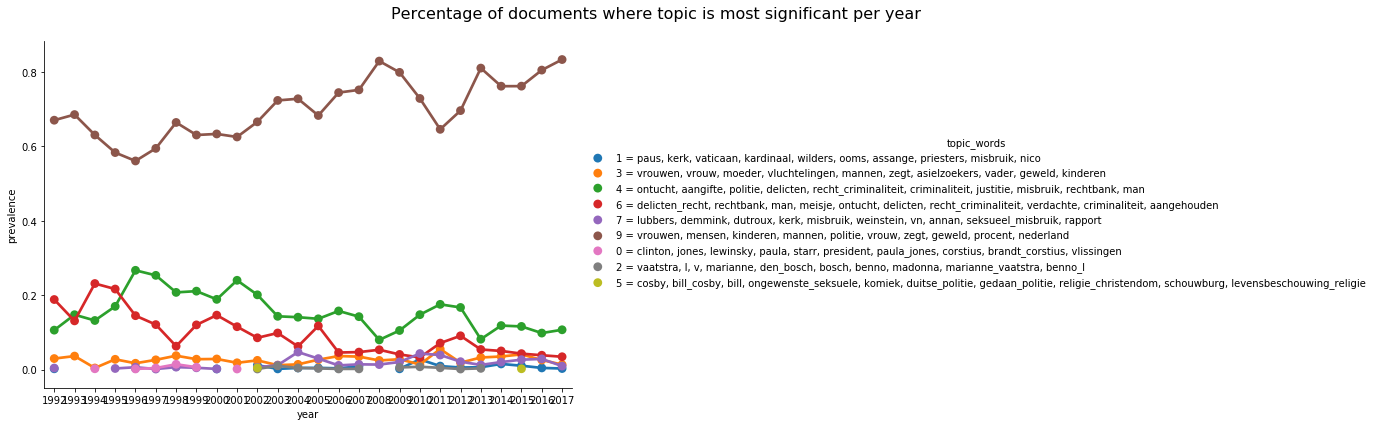

In [251]:
create_plotpoint(max_counts, 'prevalence', hue='topic_words',
                 title='Percentage of documents where topic is most significant per year'
                )

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


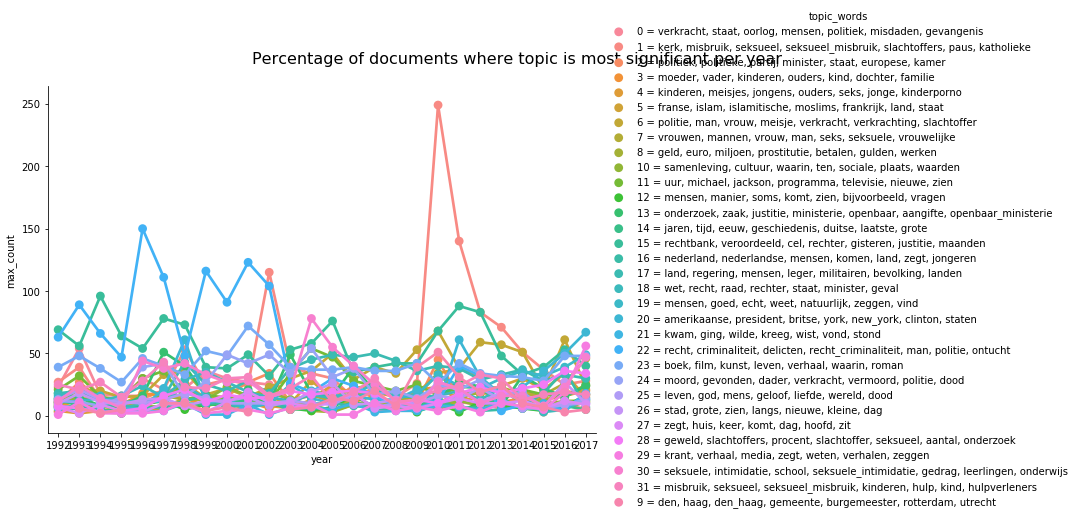

In [384]:
create_plotpoint(max_counts, 'max_count', hue='topic_words',
                 title='Percentage of documents where topic is most significant per year'
                )

In [386]:
max_counts.topic_words.value_counts()

31 = misbruik, seksueel, seksueel_misbruik, kinderen, hulp, kind, hulpverleners            26
11 = uur, michael, jackson, programma, televisie, nieuwe, zien                             26
23 = boek, film, kunst, leven, verhaal, waarin, roman                                      26
2 = politiek, politieke, partij, minister, staat, europese, kamer                          26
26 = stad, grote, zien, langs, nieuwe, kleine, dag                                         26
19 = mensen, goed, echt, weet, natuurlijk, zeggen, vind                                    26
20 = amerikaanse, president, britse, york, new_york, clinton, staten                       26
15 = rechtbank, veroordeeld, cel, rechter, gisteren, justitie, maanden                     26
0 = verkracht, staat, oorlog, mensen, politiek, misdaden, gevangenis                       26
24 = moord, gevonden, dader, verkracht, vermoord, politie, dood                            26
12 = mensen, manier, soms, komt, zien, bijvoorbeeld, vragen 

In [125]:
new[new['topic_id'] == 9]

,title,publication_date,year,doc_id,topic_id,norm_topic_weight,topic_words
152541,HIV-test voor arts na misbruik patiente,1993-10-09T00:00:00,1993,0,9,0.000827,"9 = kinderen, vrouwen, zegt, mensen, goed, sek..."
152542,vrijdag P...,2006-12-15T00:00:00,2006,1,9,0.453277,"9 = kinderen, vrouwen, zegt, mensen, goed, sek..."
152543,Bisschop Punt 'geschokt en beschaamd'; Seksue...,2010-03-15T00:00:00,2010,2,9,0.397805,"9 = kinderen, vrouwen, zegt, mensen, goed, sek..."
152544,maandag K...,2009-03-09T00:00:00,2009,3,9,0.001354,"9 = kinderen, vrouwen, zegt, mensen, goed, sek..."
152545,Opheffing van het celibaat betekent niet het ...,2010-03-15T00:00:00,2010,4,9,0.462408,"9 = kinderen, vrouwen, zegt, mensen, goed, sek..."
152546,MISBRUIK GEHANDICAPTE,1996-11-22T00:00:00,1996,5,9,0.003572,"9 = kinderen, vrouwen, zegt, mensen, goed, sek..."
152547,'Grote toename hiv-gevallen in Rwanda door ge...,1998-05-12T00:00:00,1998,6,9,0.202960,"9 = kinderen, vrouwen, zegt, mensen, goed, sek..."
152548,'Een betere naam hebben we nooit kunnen beden...,1996-11-23T00:00:00,1996,7,9,0.780415,"9 = kinderen, vrouwen, zegt, mensen, goed, sek..."
152549,'Rijkswachters betrokken bij Nijvelbende',1996-11-23T00:00:00,1996,8,9,0.430179,"9 = kinderen, vrouwen, zegt, mensen, goed, sek..."
152550,Zwarten bedanken voor 'witte aanpak' probleme...,1996-11-23T00:00:00,1996,9,9,0.663726,"9 = kinderen, vrouwen, zegt, mensen, goed, sek..."


In [265]:
dictionary = corpora.Dictionary(speeches_nl_uniandbigrams) 
doc_term_matrix = [dictionary.doc2bow(doc) for doc in speeches_nl_uniandbigrams]

In [328]:
# import logging
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm


In [329]:
Lda = models.LdaMulticore
coherenceList_umass = []
coherenceList_cv = []
num_topics_list = np.arange(3,26)
for num_topics in tqdm(num_topics_list):
    lda= Lda(doc_term_matrix, num_topics=num_topics,id2word = dictionary, 
             passes=20,chunksize=4000,random_state=43)
    cm = CoherenceModel(model=lda, corpus=doc_term_matrix, 
                        dictionary=dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    cm_cv = CoherenceModel(model=lda, corpus=doc_term_matrix,
                           texts=speeches_nl_uniandbigrams, dictionary=dictionary, coherence='c_v')
    coherenceList_cv.append(cm_cv.get_coherence())
    vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)
    pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')

  0%|          | 0/23 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_umass})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=-3.9)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')


In [ ]:
plotData = pd.DataFrame({'Number of topics':num_topics_list,
                         'CoherenceScore':coherenceList_umass})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=-3.9)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')


## Summing up
While there are different ways to achieve the desired results and different modules to help you with it (writing from scratch, NLTK, but also gensim.utils), these are some steps to consider when transforming texts to feature sets for topic modeling (recall that not all of them might be neccessary of even diserable, depending on the use case):

- transforming to lowercase
- removing stopwords
- stemming
- POS-tagging (and removing unwanted elements)
- filtering extremely common and extremely uncommon words
- ngrams and/or unigrams as features?
- raw frequencies or TF-IDF scores as features?



# 5. Evaluating and comparing different models (Tatjana/Damian)


## Perplexity

## Log perplexity
To print more info while estimating a topic model, you can either

- use the method ldamodel.bound(corpus, gamma=None, subsample_ratio=1.0) (but you need a holdout corpus)
- or just activate logging before you estimate the models:

In [ ]:
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [77]:
ldacorpus_perplex = ldacorpus_m5.copy()
random.shuffle(ldacorpus_perplex)

splitidx = int(0.8 * len(ldacorpus_perplex))

train = ldacorpus_perplex[:splitidx]
test = ldacorpus_perplex[splitidx:]


In [78]:
perplexityvalues = []
for n in [2, 3, 5, 8, 10, 20, 50, 75, 100]:
    lda = models.LdaModel(train, id2word=id2word_m1, num_topics=n)
    print(lda.log_perplexity(test), lda.bound(test))
    perplexityvalues.append((n, lda.log_perplexity(test)))

-9.175951284249109 -3283332.7133889794
-9.577074715582063 -3426906.462182045
-10.110675293765535 -3617820.0480160713
-10.813143790235468 -3869179.1998547316


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gensim/models/ldamodel.py:1030: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


-11.461331307381304 -4101121.951157987


([<matplotlib.axis.XTick at 0x155813358>,
 <a list of 5 Text xticklabel objects>)

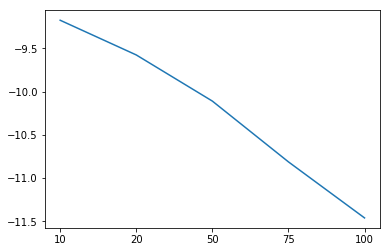

In [80]:
fig, ax = plt.subplots()
plt.plot([e[1] for e in perplexityvalues])
plt.xticks(range(len(perplexityvalues)), [e[0] for e in perplexityvalues])

-9.430153152768135 -3374266.776715368
-9.374586263637223 -3354417.5511490405
-9.545694819619634 -3415626.160475433
-9.449638981772612 -3381261.5723227262
-9.44115085865215 -3378244.921173215
-9.454504384135168 -3383004.6000258923
-9.547765068772067 -3416389.799602151
-9.53618524555596 -3412226.0337610245
-9.503538113108196 -3400558.6264121532


([<matplotlib.axis.XTick at 0x15582d208>,
 <a list of 9 Text xticklabel objects>)

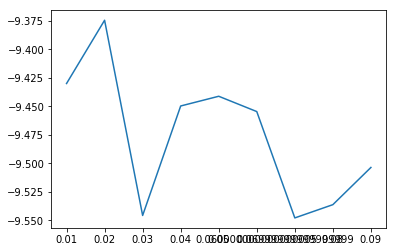

In [81]:
perplexityvalues = []

n = 20

for alpha in np.arange(0.01, 0.1, 0.01):
    lda = models.LdaModel(train, id2word=id2word_m1, num_topics=n, alpha=alpha)
    print(lda.log_perplexity(test), lda.bound(test))
    perplexityvalues.append((alpha, lda.log_perplexity(test)))
fig, ax = plt.subplots()
plt.plot([e[1] for e in perplexityvalues])
plt.xticks(range(len(perplexityvalues)), [e[0] for e in perplexityvalues])

## Topic coherence
We can calculate the Umass topic coherence for each topic. See Mimno, Wallach, Talley, Leenders, McCallum: Optimizing Semantic Coherence in Topic Models, CEMNLP 2011

In [254]:
# print coherence per topic:

lda_m5.top_topics(ldacorpus_m5)

[([(0.0021265957, 'vrouwen'),
   (0.0015680686, 'mensen'),
   (0.001544766, 'kinderen'),
   (0.0014821701, 'mannen'),
   (0.0014539852, 'politie'),
   (0.0014446005, 'vrouw'),
   (0.0013390307, 'zegt'),
   (0.0012936962, 'geweld'),
   (0.0011927609, 'procent'),
   (0.0011247947, 'nederland'),
   (0.0011053241, 'man'),
   (0.0010812683, 'leven'),
   (0.0010214553, 'goed'),
   (0.0009992035, 'seksueel'),
   (0.0009974074, 'kind'),
   (0.0009862159, 'komt'),
   (0.0009849109, 'seksuele'),
   (0.00097163883, 'komen'),
   (0.0009628477, 'ouders'),
   (0.0009605017, 'keer')],
  -1.2125194975410707),
 ([(0.006442267, 'ontucht'),
   (0.0045867944, 'aangifte'),
   (0.004428728, 'politie'),
   (0.004220458, 'delicten'),
   (0.0041183135, 'recht_criminaliteit'),
   (0.004062699, 'criminaliteit'),
   (0.0040114988, 'justitie'),
   (0.0038631647, 'misbruik'),
   (0.0035960083, 'rechtbank'),
   (0.0033489687, 'man'),
   (0.003344729, 'recht'),
   (0.003333374, 'jackson'),
   (0.0033234041, 'zedendel

In [ ]:
# Or: overall coherence
# NB: CoherenceModel is only available in newer versions of gensim.
# if it's not available, consider upgrading with `pip3 install gensim -upgrade`
cm1 = models.CoherenceModel(model=lda_m1, corpus=ldacorpus_m1, dictionary= id2word_m1, coherence='u_mass')  
naivecoh = cm1.get_coherence()
cm2 = models.CoherenceModel(model=lda_m2, corpus=ldacorpus_m2, dictionary= id2word_m2, coherence='u_mass')  
cleancoh = cm2.get_coherence()
#cm3 = models.CoherenceModel(model=lda_m3, corpus=ldacorpus_m3, coherence='u_mass')
cm3 = models.CoherenceModel(model=lda_m3, corpus=tfidfcorpus_m3[ldacorpus_m3], dictionary= id2word_m3, coherence='u_mass')
tfidfcoh = cm3.get_coherence()
cm4 = models.CoherenceModel(model=lda_m4, corpus=tfidfcorpus_m4[ldacorpus_m4], dictionary= id2word_m4, coherence='u_mass')
tfidffiltercoh = cm4.get_coherence()
print("Coherence of naive model = {}\nCoherence of clean model = {}\nCoherence of tf-idf model = {}\nCoherence of tf-idf model without extreme words {}".format(naivecoh, cleancoh, tfidfcoh,tfidffiltercoh))
print("NB: Note that it may not make too much sense to compare these vaues across different corpora")

In [255]:
lda_m5_bad = models.LdaModel(tfidfcorpus_m5[ldacorpus_m5], id2word=id2word_m5, num_topics=10,iterations=1)
print(models.CoherenceModel(model=lda_m5_bad, corpus=tfidfcorpus_m5[ldacorpus_m5], coherence='u_mass').get_coherence())

lda_m5_good = models.LdaModel(tfidfcorpus_m5[ldacorpus_m5], id2word=id2word_m5, num_topics=10,iterations=50, passes=5)
print(models.CoherenceModel(model=lda_m5_good, corpus=tfidfcorpus_m5[ldacorpus_m5], coherence='u_mass').get_coherence())

-1.6401479702001711
-7.6285061071551805


In [256]:
lda_m5_bad.top_topics(tfidfcorpus_m5[ldacorpus_m5])

[([(0.0019304331, 'politie'),
   (0.0018885978, 'vrouwen'),
   (0.0017616479, 'kinderen'),
   (0.0016793347, 'vrouw'),
   (0.001481219, 'justitie'),
   (0.0014732609, 'gisteren'),
   (0.0014715928, 'mannen'),
   (0.0014260754, 'mensen'),
   (0.0014011004, 'misbruik'),
   (0.0013953781, 'onderzoek'),
   (0.0013889045, 'slachtoffers'),
   (0.0013300759, 'meisje'),
   (0.0013299409, 'ontucht'),
   (0.0013072643, 'verkracht'),
   (0.0012637553, 'geweld'),
   (0.0012308323, 'slachtoffer'),
   (0.0011712806, 'man'),
   (0.0011633759, 'criminaliteit'),
   (0.0010869113, 'zaak'),
   (0.0010415597, 'zegt')],
  -1.3428038411673318),
 ([(0.002298248, 'vrouwen'),
   (0.0019590184, 'politie'),
   (0.0016896072, 'man'),
   (0.0014454222, 'ontucht'),
   (0.0014045592, 'zegt'),
   (0.0013877435, 'kinderen'),
   (0.0013755085, 'rechtbank'),
   (0.0013539142, 'meisje'),
   (0.0012871342, 'verdachte'),
   (0.0012478218, 'justitie'),
   (0.0012282514, 'misbruik'),
   (0.001224188, 'onderzoek'),
   (0.0012

In [257]:
lda_m5_good.top_topics(tfidfcorpus_m5[ldacorpus_m5])

[([(0.0023064557, 'politie'),
   (0.0021498322, 'kinderen'),
   (0.0020270583, 'vrouw'),
   (0.0016793414, 'meisje'),
   (0.0016153178, 'zegt'),
   (0.0015885942, 'verkracht'),
   (0.0015552423, 'man'),
   (0.0015480261, 'mannen'),
   (0.0015264766, 'vrouwen'),
   (0.0015170539, 'justitie'),
   (0.0014808895, 'slachtoffer'),
   (0.0014735478, 'onderzoek'),
   (0.0014242438, 'misbruik'),
   (0.0013980529, 'zaak'),
   (0.0013971241, 'ouders'),
   (0.0013320078, 's'),
   (0.0013266988, 'rechter'),
   (0.001286451, 'seksueel'),
   (0.0012740388, 'gisteren'),
   (0.001254693, 'meisjes')],
  -1.3927339341465503),
 ([(0.0031430211, 'film'),
   (0.0028499062, 'boek'),
   (0.002347024, 'leven'),
   (0.0020591442, 'wereld'),
   (0.001921868, 'kunst'),
   (0.0018408844, 'mensen'),
   (0.0018184385, 'goed'),
   (0.0017401328, 'verhaal'),
   (0.0017204804, 'zien'),
   (0.0016890004, 'weet'),
   (0.0016666416, 'echt'),
   (0.0015831013, 'natuurlijk'),
   (0.0015797615, 'elkaar'),
   (0.0014956123, '

In [ ]:
lda_m3.top_topics?


In [ ]:
a= cm1.get_coherence_per_topic()


In [ ]:
a[2]


# 6. Visualizing and interactively exploring topic models (Damian/Cornelius)
A great tool for interactively exploring topicmodels is pyLDAvis.
pyLDAvis can estimate its own topic models, but it als has a nice function called `gensim.prepare`, which you can use to visualize the model you already estimated with gensim.

In [282]:
vis_data = pyLDAvis.gensim.prepare(lda_m5,ldacorpus_m5,id2word_m5)
pyLDAvis.display(vis_data)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# 7. What’s the next step in the pipeline? Using the results of a topic model (Damian)

Until know, we have mainly considered the interpretation of the topics themselves. While it can indeed be interesting to use topic models to summarize and interpret large corpora, this is usually not where social scientists stop: We want to relate the topics back to documents to say something about which topics occur in which documents.

## Saving topic scores to a file
Somewhat similar to factor analysis and principal component analysis, where one can also store factor scores that indicate how high a specific case scores on each of the factors that were identified, for each document, we can estimate a score for each of the topics we identified.

To do so, we can simply call the `.inference()` method on the model we estimated. 

In [116]:
scoresperdoc=lda_m5.inference(ldacorpus_m5)

In [117]:
len(scoresperdoc[0])


16949

We could do a lot of different stuff with the resulting matrix, in which each row represents one of the documents and each row consists of one score for each topic.
For example, we just could create a tab-separated file:

In [ ]:
with open("topicscores.tsv","w",encoding="utf-8") as fo:
    for row in scoresperdoc[0]:
       fo.write("\t".join(["{:0.3f}".format(score) for score in row]))
       fo.write("\n")
        

,0,1,2,3,4,5,6
0,0.778498,0.001168,0.027240,0.189592,0.001166,0.001169,0.001167
1,0.134066,0.002709,0.002707,0.002703,0.752892,0.002706,0.102218
2,0.001132,0.001130,0.001127,0.001129,0.704369,0.001129,0.289984
3,0.001942,0.001939,0.001937,0.787856,0.202453,0.001937,0.001937
4,0.000835,0.000835,0.000833,0.000834,0.646420,0.000835,0.349408
5,0.783287,0.004791,0.004779,0.004775,0.004768,0.192822,0.004778
6,0.002280,0.002277,0.002273,0.236115,0.002280,0.752494,0.002281
7,0.003850,0.000257,0.000256,0.000257,0.754609,0.240514,0.000257
8,0.481757,0.001112,0.001110,0.001112,0.512684,0.001112,0.001112
9,0.000826,0.265038,0.000825,0.000826,0.622819,0.108839,0.000826


... or we put it into a Pandas dataframe

Max: 0.9989315332114816
Min: 0.0050043913009413495
Average: 0.32734225386694576
Median: 0.21406100769147535
Most frequent value: 0.006


We see that these scores are extremely skewed. Maybe we just want to know which topics score really high? Let's recode:

In [30]:
topics = {
    0: 'Clinton',
    1: 'International affairs',
    2: 'National affairs: Lubbers',
    3: 'Kerk',
    4: 'Victims - General',
    5: 'MeToo',
    6: 'Jackson - Child abuse',
    7: 'Daycare abuse'
}


top = ['Clinton', 'International affairs', 'National affairs: Lubbers', 'Kerk', 'Victims - General', 'MeToo', 'Jackson - Child abuse',
'Daycare abuse']

top = list(range(0,20))
#new.columns
top

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [31]:
new['Max'] = new[top].idxmax(axis=1)
new['Max'].value_counts()

12    7818
16    6126
8     1390
1      420
3      365
14     312
7      118
5       90
19      76
6       59
10      54
2       32
4       24
17      24
0       16
18      13
13       8
15       3
11       1
Name: Max, dtype: int64

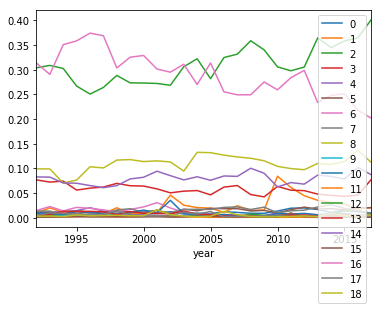

In [33]:
d ={0: 'mean', 1 : 'mean', 
   2  : 'mean', 
   3  : 'mean',
   4  : 'mean',
   5 :   'mean',
  6:  'mean',
  7:  'mean',
  8: 'mean',
  9: 'mean',
   10 : 'mean',11 : 'mean',12 :'mean',13 : 'mean', 14 : 'mean' , 15: 'mean' , 16 : 'mean' , 17 : 'mean', 18 : 'mean'
   }


new.groupby('year').agg(d).plot()

In [199]:
new['1_relative']
new


,title,title_rss,doctype,publication_date,byline,teaser_rss,url,text,date,year,...,Kerk,Victims - General,MeToo,Jackson - Child abuse,Daycare abuse,sum,Max,0_relative,1_relative,2_relative
1,HIV-test voor arts na misbruik patiente,NaN,trouw (print),1993-10-09T00:00:00,NaN,NaN,NaN,HAARLEM (ANP) - Een huisarts uit Velsen die d...,1993-10-09,1993,...,49.102676,0.125146,0.125177,0.125022,0.125101,49.978299,Kerk,0.250184,0.250291,0.250203
2,vrijdag P...,NaN,trouw (print),2006-12-15T00:00:00,NaN,NaN,NaN,Nederlands geref. kerken Afscheid 17/12: van ...,2006-12-15,2006,...,90.710716,30.454918,0.125155,0.125041,0.125141,121.916148,Kerk,0.102572,0.102571,0.102591
3,Bisschop Punt 'geschokt en beschaamd'; Seksue...,NaN,trouw (print),2010-03-15T00:00:00,Van onze verslaggeefster,NaN,NaN,"amsterdam - ,,Uit wat tot nu toe naar boven i...",2010-03-15,2010,...,0.125186,0.125156,59.088028,0.125073,0.125109,59.963928,MeToo,0.208537,0.208698,0.208770
4,maandag K...,NaN,trouw (print),2009-03-09T00:00:00,NaN,NaN,NaN,DATELINE: tel aviv - tel aviv - Na meer dan t...,2009-03-09,2009,...,119.872742,49.258808,0.125170,0.125029,0.125201,169.882164,Kerk,0.073609,0.073626,0.073633
5,Opheffing van het celibaat betekent niet het ...,NaN,trouw (print),2010-03-15T00:00:00,NaN,NaN,NaN,Ook in Nederland is een stroom weerzinwekken...,2010-03-15,2010,...,28.119490,0.125047,0.125021,0.125024,0.125060,28.994970,Kerk,0.431219,0.431313,0.431927
6,MISBRUIK GEHANDICAPTE,NaN,trouw (print),1996-11-22T00:00:00,NaN,NaN,NaN,De St.-Augustinusstichting in Gennep verdenkt...,1996-11-22,1996,...,2.330525,36.039429,0.125169,0.125032,0.125105,57.968888,Victims - General,0.215810,32.730260,0.215905
7,'Grote toename hiv-gevallen in Rwanda door ge...,NaN,trouw (print),1998-05-12T00:00:00,NaN,NaN,NaN,KIGALI (AP) - Het aantal hiv-lijders onder de...,1998-05-12,1998,...,0.125230,341.150848,175.592514,0.125067,0.125104,517.494008,Victims - General,0.024169,0.024172,0.024171
8,'Een betere naam hebben we nooit kunnen beden...,NaN,trouw (print),1996-11-23T00:00:00,FRED LAMMERS,NaN,NaN,Twintig keer per jaar wordt Arts & Auto bij 6...,1996-11-23,1996,...,0.125208,121.041473,0.125226,0.125073,0.125145,121.917571,Victims - General,0.102577,0.102644,0.102729
9,'Rijkswachters betrokken bij Nijvelbende',NaN,trouw (print),1996-11-23T00:00:00,NaN,NaN,NaN,Van onze correspondent BRUSSEL - Een bekende ...,1996-11-23,1996,...,0.125188,82.375221,70.735542,0.125036,0.125080,153.861469,Victims - General,0.081306,0.081365,0.081315
10,Zwarten bedanken voor 'witte aanpak' probleme...,NaN,trouw (print),1996-11-23T00:00:00,NaN,NaN,NaN,Van een onzer verslaggevers AMSTERDAM - De so...,1996-11-23,1996,...,14.243254,389.611755,252.880829,0.125126,0.125077,657.361500,Victims - General,0.019027,0.019035,0.019054


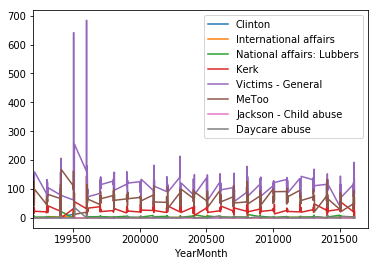

In [203]:
d = {   'Clinton': 'mean', 
 'International affairs': 'mean', 
'National affairs: Lubbers': 'mean', 
'Kerk': 'mean', 
'Victims - General': 'mean', 
'MeToo':'mean', 
 'Jackson - Child abuse': 'mean', 
'Daycare abuse': 'mean'
    
}

#df2_yearly = new.groupby('year', as_index=False).agg({'0': 'mean, '1': 'mean'})
new.groupby('YearMonth').agg(d).plot()


Or a heatmap?

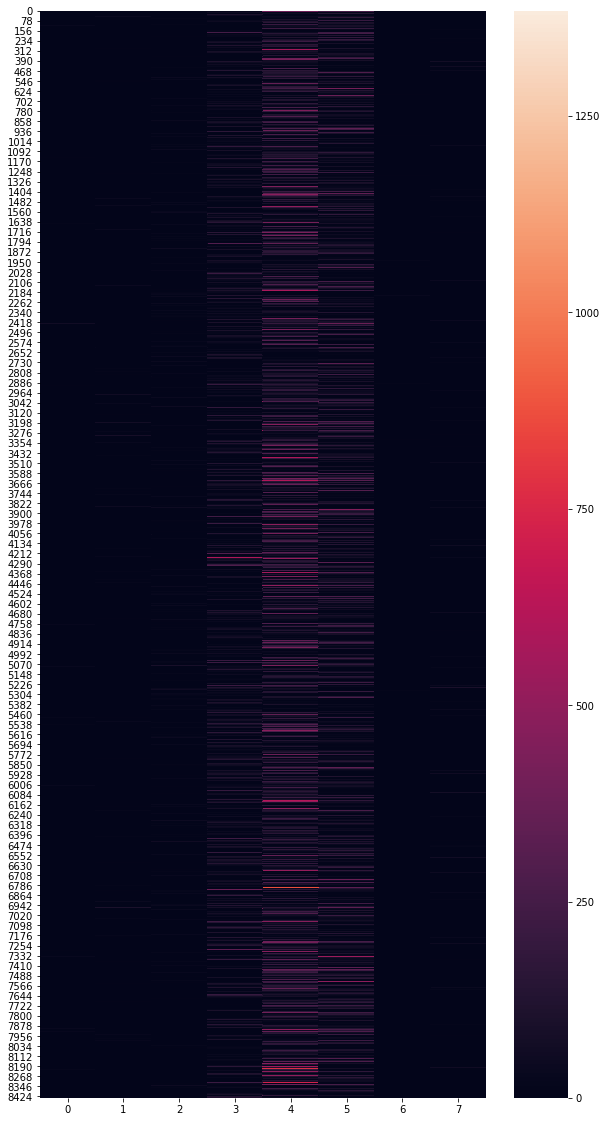

In [113]:
plt.figure(figsize=(10, 20))
sns.heatmap(df)


# Tuning alpha and eta
different parameters. From docstring:
```
`alpha` and `eta` are hyperparameters that affect sparsity of the document-topic
(theta) and topic-word (lambda) distributions. Both default to a symmetric
1.0/num_topics prior.

`alpha` can be set to an explicit array = prior of your choice. It also
support special values of 'asymmetric' and 'auto': the former uses a fixed
normalized asymmetric 1.0/topicno prior, the latter learns an asymmetric
prior directly from your data.

`eta` can be a scalar for a symmetric prior over topic/word
distributions, or a matrix of shape num_topics x num_words, which can
be used to impose asymmetric priors over the word distribution on a
per-topic basis. This may be useful if you want to seed certain topics
with particular words by boosting the priors for those words.  It also
supports the special value 'auto', which learns an asymmetric prior
directly from your data.
```


In [233]:
# example for different specification: repeat analysis 10 times, while learning alpha and eta from the data 
# instead of using 1/number of topics as defailt

lda_m6 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m5[ldacorpus_m5],id2word=id2word_m5,num_topics=50, alpha='auto', eta = 'auto',passes=10)

In [234]:
vis_data = pyLDAvis.gensim.prepare(lda_m6,ldacorpus_m5,id2word_m5)
pyLDAvis.display(vis_data)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [ ]:
pyLDAvis.show(vis_data)

# Handle with care! Topic model with *all* documents - will take a while to run

In [ ]:
#filelist = glob('Cleaned_Speeches/Speeches_*_Cleaned.csv')
# instead of all speeches, to speed up things, we are focusing on speeches from the Netherlands only
filelist = glob('/home/damian/Downloads/Cleaned_Speeches/Speeches_*_Cleaned.csv')
print(filelist)
speeches=[]
for fn in filelist:
    with open(fn) as fi:
        reader=csv.reader(fi)
        for row in reader:
            if row[7]=='en':   # only include english-language speches; we might as well choose 'nl' or 'fr'
                speeches.append(row[5])
print(len(speeches))

In [ ]:
speeches=[speech.replace('<p>',' ').replace('</p>',' ') for speech in speeches]   #remove HTML tags
speeches=["".join([l for l in speech if l not in punctuation]) for speech in speeches]  #remove punctuation
speeches=[speech.lower() for speech in speeches]  # convert to lower case
speeches=[" ".join([w for w in speech.split() if w not in mystopwords]) for speech in speeches] # remove stopwords

In [ ]:
ldainput_m99 = [speech.split() for speech in speeches]           
id2word_m99 = corpora.Dictionary(ldainput_m99)                       

id2word_m99.filter_extremes(no_below=5, no_above=0.5)   # do not consider all words that occur in less than n=5 documents
                                                    # or in more than 50% of all documents.

ldacorpus_m99 = [id2word_m99.doc2bow(doc) for doc in ldainput_m99]
tfidfcorpus_m99 = models.TfidfModel(ldacorpus_m99)
lda_m99 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m99[ldacorpus_m99],id2word=id2word_m99,num_topics=50, passes=5, eta='auto',alpha='auto')
lda_m99.print_topics(num_words=5)


In [ ]:
vis_data = pyLDAvis.gensim.prepare(lda_m99,ldacorpus_m99,id2word_m99)
pyLDAvis.display(vis_data)


In [ ]:
print("FINISHED RUNNING:",str(datetime.now()))


In [57]:
from sklearn.feature_extraction.text import CountVectorizer
reviews = ['this is whatever weird sentence could be', 'this is a second']
vectorizer = CountVectorizer(stop_words = 'english')
train_features = vectorizer.fit_transform([r for r in reviews])

In [61]:
train_features.

<2x3 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [315]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus= ldacorpus_m5, num_topics= num_topics, id2word=id2word_m5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [283]:
import os
from gensim.models.wrappers import LdaMallet

mallet_path = '/Users/anne/Desktop/mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=ldacorpus_m5, num_topics=20, id2word=id2word_m5)

In [302]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

NameError: name 'corpus' is not defined

In [308]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=ldacorpus_m5, texts=speeches_nl_uniandbigrams, start=2, limit=50, step=5)

In [335]:
coherence_values

[0.33993042985717237,
 0.41644626535519447,
 0.4477144349093674,
 0.45368202555744136,
 0.46514795136606646,
 0.48802283165658766,
 0.4840827327315207]

In [332]:
#pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=speeches_nl_uniandbigrams, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4462877958415767


In [360]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=ldacorpus_m5, num_topics=32, id2word=id2word_m5)

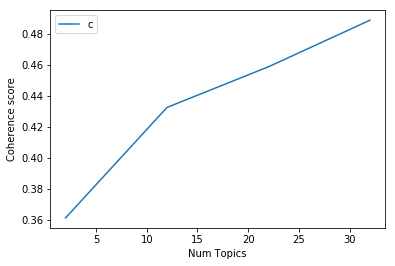

In [353]:
limit=45; start=2; step=10;

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=tfidfcorpus_m5[ldacorpus_m5],
                                           id2word=id2word_m5,
                                           num_topics=32, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [358]:
NUM_TOPICS = 10
lda_m5 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m5[ldacorpus_m5],id2word=id2word_m5,num_topics=NUM_TOPICS, 
                                        random_state=100,
                                        update_every=1,
                                        chunksize=100,
                                        passes=10,
                                        alpha='auto',
                                        per_word_topics=True)

In [340]:
from pprint import pprint

In [361]:
ldamallet.show_topics(num_topics=-1, num_words=4, formatted=False)
#doc_lda = lda_model[tfidfcorpus_m5[ldacorpus_m5]]

[(0,
  [('verkracht', 0.018138625621736657),
   ('staat', 0.017371507757788722),
   ('oorlog', 0.00842592363465393),
   ('mensen', 0.007881517408626365)]),
 (1,
  [('kerk', 0.059158157315675794),
   ('misbruik', 0.05628846953365038),
   ('seksueel', 0.03564294188628735),
   ('seksueel_misbruik', 0.03405092428283156)]),
 (2,
  [('politiek', 0.02984893727205615),
   ('politieke', 0.019249203918155072),
   ('partij', 0.018510968850887533),
   ('minister', 0.018422821380169024)]),
 (3,
  [('moeder', 0.046107522704094024),
   ('vader', 0.0435918605215871),
   ('kinderen', 0.04083337380408916),
   ('ouders', 0.03413141663833714)]),
 (4,
  [('kinderen', 0.08277966435356071),
   ('meisjes', 0.05199566907820267),
   ('jongens', 0.04891973030168807),
   ('ouders', 0.022368226782814114)]),
 (5,
  [('franse', 0.014045276757141165),
   ('islam', 0.011651060803603177),
   ('moslims', 0.011259926514163802),
   ('islamitische', 0.011259926514163802)]),
 (6,
  [('politie', 0.07666217534730288),
   ('ma